In [1]:
import keras
keras.__version__

Using TensorFlow backend.


'2.3.1'

In [2]:
import os
import cv2
import numpy as np
import pickle # buat save model
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras.layers import Dropout,Flatten
from keras.layers.convolutional import Conv2D,MaxPooling2D

In [3]:
path = 'myData'
testRatio = 0.2
valRatio = 0.2
imageDimensions= (32,32,3)
batchSizeVal= 50
epochsVal = 1
stepsPerEpochVal = 2000

In [4]:
classNo = []
images = []
myList = os.listdir(path)

In [5]:
print("Total No of Classes Detected : ", len(myList))

Total No of Classes Detected :  10


In [6]:
noOfClasses = len(myList)
list_dir = []
print("Importing Classes.........")
for x in range(0,noOfClasses):
    myPicList = os.listdir(path+"/"+str(x))
    list_dir.append(myPicList)
    for y in myPicList:
        curImg = cv2.imread(path+"/"+str(x)+"/"+y)
        curImg = cv2.resize(curImg,(imageDimensions[0],imageDimensions[1]))
        images.append(curImg) # ini image di save di list dulu smua, baru muncul nama kelasnya
        classNo.append(x) # save the corresponding image_id, x=0 maka class=0, dst
    print(x,end=" ")
    # jadi print(len(curImg)) dan print(len(classNo)) adalah total 10160
print(" ")

Importing Classes.........
0 1 2 3 4 5 6 7 8 9  


In [7]:
np.array(classNo).shape

(10160,)

In [54]:
# len(np.array(list_dir)[7])

In [55]:
# np.array(list_dir).reshape(-1,)

In [22]:
#### CONVERT TO NUMPY ARRAY
images_ = np.array(images)
classNo = np.array(classNo)

In [23]:
X_train,X_test,y_train,y_test = train_test_split(images_,classNo,test_size=testRatio)
X_train,X_validation,y_train,y_validation = train_test_split(X_train,y_train,test_size=valRatio) 

In [24]:
#### PLOT BAR CHART FOR DISTRIBUTION OF IMAGES
#check how many images of each class
numOfSamples = []
for x in range(0,noOfClasses):
    #print(len(np.where(y_train==x)[0]))
    numOfSamples.append(len(np.where(y_train==x)[0]))
print(numOfSamples)

[680, 646, 674, 632, 639, 653, 645, 636, 657, 640]


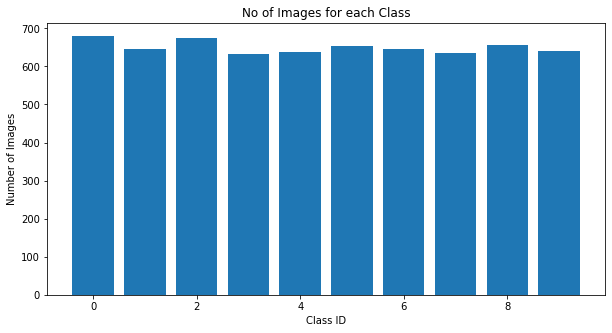

In [25]:
plt.figure(figsize=(10,5))
plt.bar(range(0,noOfClasses),numOfSamples) #X,y
plt.title("No of Images for each Class")
plt.xlabel("Class ID")
plt.ylabel("Number of Images")
plt.show()

In [58]:
# from PIL import Image
# from PIL import ImageFilter

In [59]:
# def minus(x):
#     return (max(numOfSamples)-x)
# delta = map(minus, numOfSamples)
# list(delta)

In [60]:
# for count in range(0, noOfClasses):
#     print(count)

In [61]:
# r,g,b = Image.open(path+"/"+str(0)+"/"+'img001-00001.png').convert("RGB").split()

In [62]:
# r=r.convert("RGB")

In [63]:
#### PREPOSSESSING FUNCTION FOR IMAGES FOR TRAINING
def preProcessing(img):
    img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    img = cv2.equalizeHist(img) # Makes the lighting of image distribute evenly
    img = img/255
    return img 

In [64]:
X_train = np.array(list(map(preProcessing,X_train))) # store new preProcessed data in X_train
                                                     # mengubah 3 dimensional jadi 1 dimensional
X_test = np.array(list(map(preProcessing,X_test)))
X_validation = np.array(list(map(preProcessing,X_validation)))

In [66]:
#### RESHAPE IMAGES 
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1],X_train.shape[2],1) # jumlah data, lebar pixel, tinggi pixel, depth=1
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1],X_test.shape[2],1)
X_validation = X_validation.reshape(X_validation.shape[0],X_validation.shape[1],X_validation.shape[2],1)

In [67]:
#### IMAGE AUGMENTATION
dataGen = ImageDataGenerator(width_shift_range=0.1, # pergeseran lebar 10%
                             height_shift_range=0.1, # pergeseran tinggi 10%
                             zoom_range=0.2, # zoom in and zoom out 20%
                             shear_range=0.1, # potong 10%
                             rotation_range=10) # rotation 10 derajat
dataGen.fit(X_train)

In [68]:
#### ONE HOT ENCODING OF MATRICES
y_train = to_categorical(y_train,noOfClasses)
y_test = to_categorical(y_test,noOfClasses)
y_validation = to_categorical(y_validation,noOfClasses)

In [69]:
#### CREATING THE MODEL
def myModel():
    # Adaptate the lynette model
    noOfFilters = 60
    sizeOfFilter1 = (5,5)
    sizeOfFilter2 = (3, 3)
    sizeOfPool = (2,2)
    noOfNodes= 500

    model = Sequential()
    model.add((Conv2D(noOfFilters,sizeOfFilter1,input_shape=(imageDimensions[0], imageDimensions[1],1),activation='relu'))) # input pake grayscale image
    model.add((Conv2D(noOfFilters, sizeOfFilter1, activation='relu')))
    model.add(MaxPooling2D(pool_size=sizeOfPool)) # ngebagi 2 shape[0] dan shape[1]
    model.add((Conv2D(noOfFilters//2, sizeOfFilter2, activation='relu')))
    model.add((Conv2D(noOfFilters//2, sizeOfFilter2, activation='relu')))
    model.add(MaxPooling2D(pool_size=sizeOfPool))
    model.add(Dropout(0.5))
    
    model.add(Flatten()) # ubah jadi 1D, fully connected
    model.add(Dense(noOfNodes,activation='relu'))
    model.add(Dropout(0.5)) # reduce overfittin and making more generic
    model.add(Dense(noOfClasses, activation='softmax'))
 
    model.compile(Adam(lr=0.001),loss='categorical_crossentropy',metrics=['accuracy']) # compile dulu baru fit
    return model

model = myModel()
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 60)        1560      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 60)        90060     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 60)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 10, 10, 30)        16230     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 8, 8, 30)          8130      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 4, 30)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 4, 4, 30)         

In [70]:
#### STARTING THE TRAINING PROCESS
history = model.fit_generator(dataGen.flow(X_train,y_train,
                                 batch_size=batchSizeVal),
                                 steps_per_epoch=stepsPerEpochVal,
                                 epochs=epochsVal,
                                 validation_data=(X_validation,y_validation),
                                 shuffle=1)

Epoch 1/1
2000/2000 [==============================] - 4277s 2s/step - loss: 0.2479 - accuracy: 0.9186 - val_loss: 0.0257 - val_accuracy: 0.9938


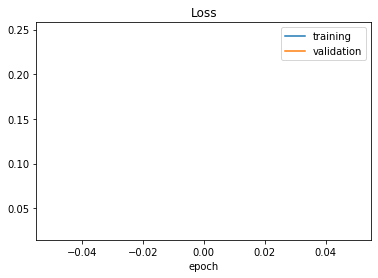

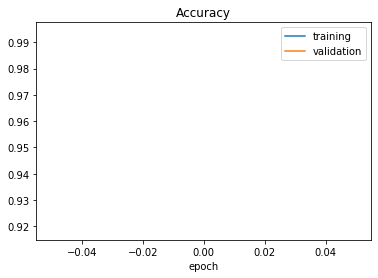

In [73]:
#### PLOT THE RESULTS  (ngetest seberapa baik model)
plt.figure(1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training','validation'])
plt.title('Loss')
plt.xlabel('epoch')
plt.figure(2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['training','validation'])
plt.title('Accuracy')
plt.xlabel('epoch')
plt.show()

In [72]:
#### EVALUATE USING TEST IMAGES (ngetest seberapa baik hasil)
score = model.evaluate(X_test,y_test,verbose=0)
print('Test Score = ',score[0])
print('Test Accuracy =', score[1])

Test Score =  0.017822341173273092
Test Accuracy = 0.9940944910049438


In [74]:
## loss: 0.2479 - accuracy: 0.9186 - val_loss: 0.0257 - val_accuracy: 0.9938

#### SAVE THE TRAINED MODEL 
pickle_out= open("model_trained_2.p", "wb")
pickle.dump(model,pickle_out)
pickle_out.close()